## Just Vizualize some samples

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

from src.common import load_data, prepare_train_data
from src.eval import visualize_retrieval
from train_mrr import (
    MLP,
    MODEL_PATH,
    VAL_RATIO,
    RANDOM_SEED,
    DEVICE,
    MODEL_PATH_MRR,
    seed_everything,
)

# 1) Recreate the image-based validation split
seed_everything(RANDOM_SEED)

train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)

caption_image_ids = torch.argmax(label.float(), dim=1).long()
num_images = label.shape[1]

g = torch.Generator().manual_seed(RANDOM_SEED)
permuted = torch.randperm(num_images, generator=g)
num_val_images = max(1, int(num_images * VAL_RATIO))
val_image_ids = permuted[-num_val_images:]
val_image_mask = torch.zeros(num_images, dtype=torch.bool)
val_image_mask[val_image_ids] = True

val_mask = val_image_mask[caption_image_ids]
val_text_embd = X[val_mask]
val_caption_ids = caption_image_ids[val_mask]

val_caption_text = train_data["captions/text"][val_mask.cpu().numpy()]
val_img_mask = val_image_mask.cpu().numpy()
val_img_names = train_data["images/names"][val_img_mask]
val_img_embd = torch.from_numpy(train_data["images/embeddings"][val_img_mask]).float()

# Map original image ids -> contiguous indices within the validation image pool
image_id_to_val_idx = {
    int(orig_id): idx for idx, orig_id in enumerate(torch.arange(num_images)[val_img_mask])
}
val_label = np.array([image_id_to_val_idx[int(img_id)] for img_id in val_caption_ids])

# 2) Run best baseline (train_mrr) checkpoint on all validation captions
model = MLP().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH_MRR, map_location=DEVICE))
model.eval()

val_ds = TensorDataset(val_text_embd, val_caption_ids)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

pred_chunks = []
with torch.no_grad():
    for text_batch, _ in val_loader:
        preds = model(text_batch.to(DEVICE))
        pred_chunks.append(preds.cpu())
val_preds = torch.cat(pred_chunks, dim=0)

# 3) Visualize a handful of random captions
num_samples = min(20, len(val_preds))
sample_indices = np.random.choice(len(val_preds), size=num_samples, replace=False)

for idx in sample_indices:
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]
    pred_embed = val_preds[idx].unsqueeze(0)  # visualize_retrieval expects [1, dim]

    visualize_retrieval(
        pred_embed,
        gt_index,
        val_img_names,
        caption_text,
        val_img_embd,
        k=10,
    )

## Examples that were hard for the model

In [ ]:
import torch.nn.functional as F

chunk_size = 1024
k_visualize = 8
max_examples_to_show = 20
margin_threshold = 0.05  # how close a correct match can be to a negative when rank == 1

norm_caption_emb = F.normalize(val_preds, dim=-1)
norm_image_emb = F.normalize(val_img_embd, dim=-1)
gt_tensor = torch.from_numpy(val_label).long()

hard_examples = []
for start in range(0, norm_caption_emb.size(0), chunk_size):
    end = min(start + chunk_size, norm_caption_emb.size(0))
    preds_chunk = norm_caption_emb[start:end]
    labels_chunk = gt_tensor[start:end]
    sims = preds_chunk @ norm_image_emb.T

    correct_scores = sims[torch.arange(sims.size(0)), labels_chunk]
    mask = torch.zeros_like(sims, dtype=torch.bool)
    mask[torch.arange(sims.size(0)), labels_chunk] = True
    best_neg_scores = sims.masked_fill(mask, float("-inf")).max(dim=1).values
    best_neg_scores = torch.where(torch.isinf(best_neg_scores), correct_scores, best_neg_scores)
    ranks = (sims > correct_scores.unsqueeze(1)).sum(dim=1) + 1
    margins = correct_scores - best_neg_scores

    for local_idx in range(sims.size(0)):
        rank = int(ranks[local_idx].item())
        margin = float(margins[local_idx].item())
        if rank == 1 and margin > margin_threshold:
            continue
        hard_examples.append(
            {
                "idx": start + local_idx,
                "rank": rank,
                "margin": margin,
                "caption": val_caption_text[start + local_idx],
            }
        )

if not hard_examples:
    print("No hard examples found with the current thresholds.")
else:
    hard_examples.sort(key=lambda x: (x["rank"] == 1, x["margin"]))
    hard_examples = hard_examples[:max_examples_to_show]

    for example in hard_examples:
        idx = example["idx"]
        gt_idx = int(val_label[idx])
        print("-" * 80)
        print(
            f"Caption #{idx} | Rank={example['rank']} | Margin={example['margin']:.3f} | GT image: {val_img_names[gt_idx]}"
        )
        print(example["caption"])
        visualize_retrieval(
            val_preds[idx].unsqueeze(0),
            gt_idx,
            val_img_names,
            example["caption"],
            val_img_embd,
            k=k_visualize,
        )



## Split the dataset based on our baseline model
- if our predicted image is not in top 50, drop that sample

In [ ]:
from pathlib import Path
from tqdm import tqdm

TOP_K_FILTER = 50
PRED_BATCH_SIZE = 1024
SIM_CHUNK_SIZE = 512
MAX_SUSPECT_VIZ = 5
filtered_dir = Path("data/filtered")
filtered_dir.mkdir(parents=True, exist_ok=True)
clean_dataset_path = filtered_dir / "train_clean_top50.npz"
suspect_dataset_path = filtered_dir / "train_suspect_top50.npz"

# 1) Embed all captions with the current model
full_dataset = TensorDataset(X, caption_image_ids)
full_loader = DataLoader(full_dataset, batch_size=PRED_BATCH_SIZE, shuffle=False)
model.eval()
all_caption_preds = []
with torch.no_grad():
    for text_batch, _ in tqdm(full_loader, desc="Embedding all captions"):
        preds = model(text_batch.to(DEVICE)).cpu()
        all_caption_preds.append(preds)
all_caption_preds = torch.cat(all_caption_preds, dim=0)

# 2) Check whether each ground-truth image appears in the top-k list
norm_caption_preds = F.normalize(all_caption_preds, dim=-1)
all_image_embd = torch.from_numpy(train_data["images/embeddings"]).float()
norm_image_embd = F.normalize(all_image_embd, dim=-1)
num_captions = norm_caption_preds.size(0)

hit_mask = torch.zeros(num_captions, dtype=torch.bool)
gt_ranks = torch.full((num_captions,), -1, dtype=torch.int32)

for start in tqdm(range(0, num_captions, SIM_CHUNK_SIZE), desc="Computing top-k hits"):
    end = min(start + SIM_CHUNK_SIZE, num_captions)
    sims = norm_caption_preds[start:end] @ norm_image_embd.T
    top_vals, top_idx = sims.topk(TOP_K_FILTER, dim=1)
    gt_chunk = caption_image_ids[start:end]
    matches = top_idx == gt_chunk.unsqueeze(1)
    chunk_hits = matches.any(dim=1)
    hit_mask[start:end] = chunk_hits
    ranks = torch.argmax(matches.int(), dim=1) + 1
    gt_ranks[start:end] = torch.where(chunk_hits, ranks, torch.full_like(ranks, -1))

clean_mask = hit_mask.numpy()
suspect_mask = ~clean_mask
rank_np = gt_ranks.numpy()
print(f"Total captions: {num_captions:,}")
print(f"Clean captions (GT in top-{TOP_K_FILTER}): {clean_mask.sum():,}")
print(f"Suspect captions: {suspect_mask.sum():,}")

# 3) Export filtered datasets
caption_keys = [key for key in train_data.keys() if key.startswith("captions/")]
image_keys = [key for key in train_data.keys() if key.startswith("images/")]
other_keys = [key for key in train_data.keys() if key not in caption_keys + image_keys]

def export_subset(mask, output_path):
    subset = {}
    for key in caption_keys:
        subset[key] = train_data[key][mask]
    for key in image_keys + other_keys:
        subset[key] = train_data[key]
    np.savez_compressed(output_path, **subset)
    print(f"→ Saved {output_path} ({subset[caption_keys[0]].shape[0]:,} captions)")

export_subset(clean_mask, clean_dataset_path)
export_subset(suspect_mask, suspect_dataset_path)

# 4) Visualize a few suspect samples
suspect_indices = np.flatnonzero(suspect_mask)
if suspect_indices.size == 0:
    print("No suspect examples to visualize.")
else:
    rng = np.random.default_rng(RANDOM_SEED)
    num_show = min(MAX_SUSPECT_VIZ, suspect_indices.size)
    sample_indices = rng.choice(suspect_indices, size=num_show, replace=False)
    image_names = train_data["images/names"]
    caption_texts = train_data["captions/text"]

    for idx in sample_indices:
        gt_idx = int(caption_image_ids[idx].item())
        caption = caption_texts[idx]
        print("-" * 90)
        print(
            f"Caption #{idx} | GT rank={rank_np[idx]} | GT image={image_names[gt_idx]}"
        )
        print(caption)
        visualize_retrieval(
            all_caption_preds[idx].unsqueeze(0),
            gt_idx,
            image_names,
            caption,
            all_image_embd,
            k=8,
        )



In [ ]:
# Helper cell: inspect whether specific image filenames fall into the suspect set
query_image_names = [
    "3401343154.jpg",
    "3162399420.jpg",
]

image_name_to_idx = {name: idx for idx, name in enumerate(train_data["images/names"])}
caption_texts = train_data["captions/text"]
suspect_mask_tensor = torch.from_numpy(suspect_mask)

for image_name in query_image_names:
    print("=" * 100)
    if image_name not in image_name_to_idx:
        print(f"Image '{image_name}' not found in train_data[\"images/names\"].")
        continue

    image_idx = image_name_to_idx[image_name]
    caption_indices = torch.nonzero(caption_image_ids == image_idx, as_tuple=False).squeeze()
    if caption_indices.numel() == 0:
        print(f"No captions referencing image '{image_name}'.")
        continue

    caption_indices = caption_indices.flatten()
    suspect_flags = suspect_mask_tensor[caption_indices]
    total = caption_indices.numel()
    suspect_count = int(suspect_flags.sum().item())
    clean_count = total - suspect_count

    print(
        f"Image '{image_name}' (id={image_idx}): {suspect_count}/{total} captions flagged as suspect, {clean_count} clean."
    )

    if suspect_count > 0:
        print("Suspect captions:")
        for idx in caption_indices[suspect_flags]:
            print(f"  • Caption #{int(idx)}: {caption_texts[int(idx)]}")
    else:
        print("No suspect captions for this image.")



## Vizualize poor and best pairs based on CLIP scores (Optional)

Computing CLIP scores (this may take a few minutes)...


/root/aml_challenge/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Encoding captions with CLIP: 100%|██████████| 489/489 [02:28<00:00,  3.30it/s]


Saved CLIP scores to data/filtered/train_clean_clip_scores.npy
Scores shape: (125000,), min=-0.063, max=0.504, mean=0.313


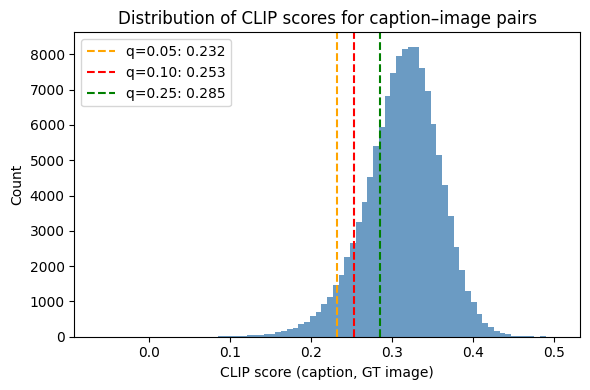

8 lowest CLIP scores (likely mismatches)
[idx=113263] image=530472459.jpg | score=-0.063
Five ladies wearing leotards and ballerina shoes practicing in a studio .
--------------------------------------------------------------------------------


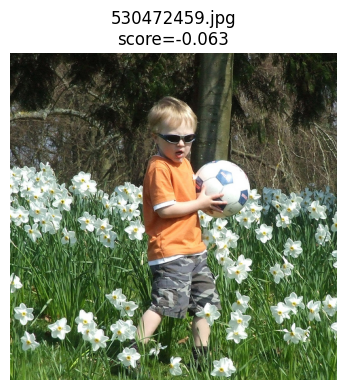

[idx=2243] image=6387209003.jpg | score=-0.023
Four ladies and one man practicing music in a living room .
--------------------------------------------------------------------------------


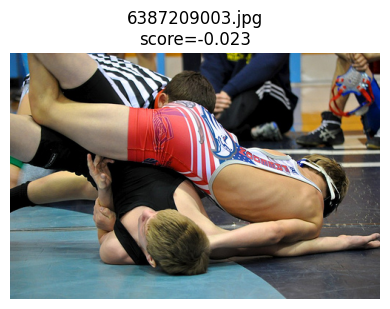

[idx=29] image=5566135246.jpg | score=-0.003
Two men heading home up the river shore .
--------------------------------------------------------------------------------


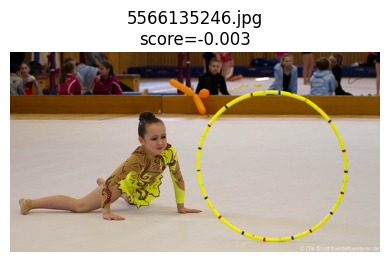

[idx=68008] image=211402278.jpg | score=0.027
Two men are paddling a boat , by a lot of trees .
--------------------------------------------------------------------------------


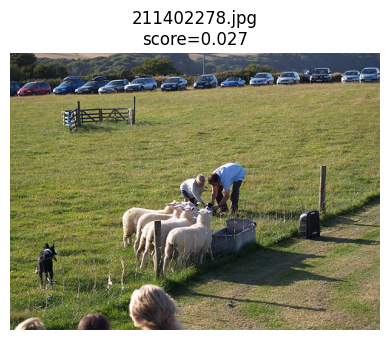

[idx=96313] image=3401343154.jpg | score=0.033
This is a small stamp with blue skies and white lines with green bushes .
--------------------------------------------------------------------------------


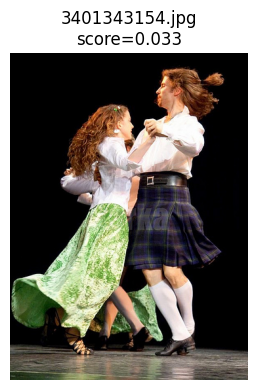

[idx=26717] image=4645332265.jpg | score=0.036
The tennis player with the blue hat and green shirt , served the ball with top spin on the ball .
--------------------------------------------------------------------------------


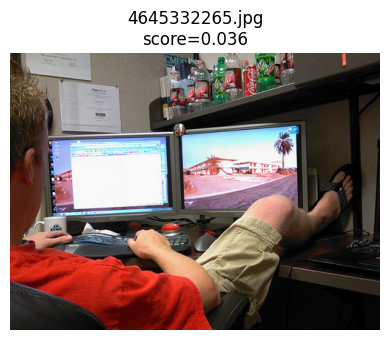

[idx=118423] image=3816107544.jpg | score=0.038
This bathtub is not staying in the old house .
--------------------------------------------------------------------------------


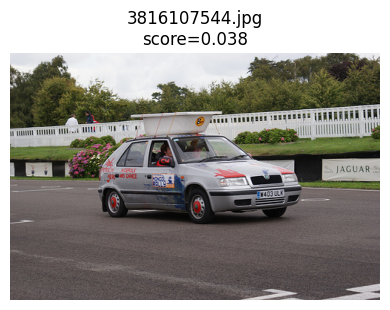

[idx=93108] image=4829856573.jpg | score=0.049
A man in black jacket and helmet at his hand poses with a smile .
--------------------------------------------------------------------------------


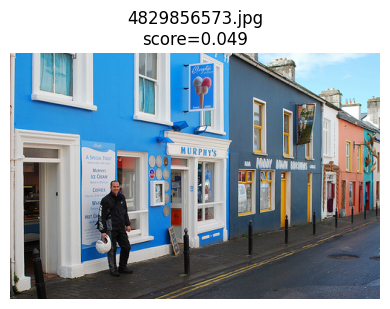

8 highest CLIP scores
[idx=111260] image=4932786099.jpg | score=0.484
An elderly woman pushing a cart filled with boxes walks by theater sign for " South Pacific " .
--------------------------------------------------------------------------------


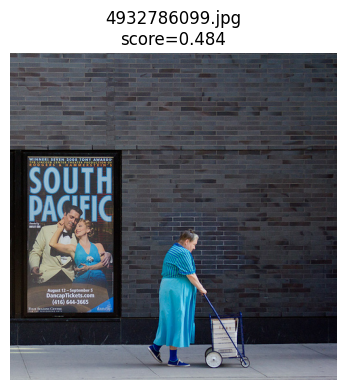

[idx=67466] image=429498940.jpg | score=0.485
Three people are sitting at a small table near a screen with the words , " DEMOS , The Business of Care . 
--------------------------------------------------------------------------------


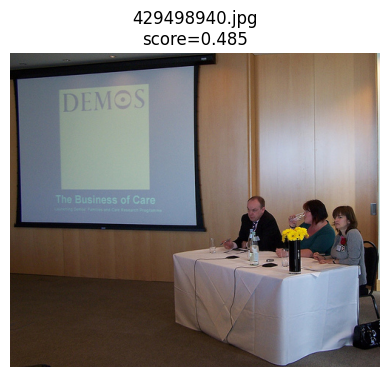

[idx=111270] image=4504050190.jpg | score=0.485
A young girl 's hand with blue nail polish and a tattoo that says ' no regrets ' in cursive lettering is clenched in a loose fist in front of a black and white zippered handbag .
--------------------------------------------------------------------------------


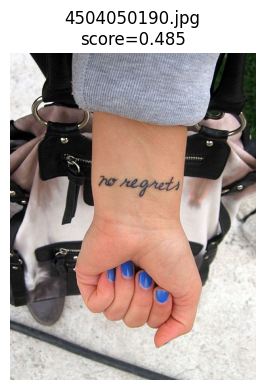

[idx=111271] image=4504050190.jpg | score=0.488
A women` s hand and arm with blue fingernail polish and a tattoo that reads no regrets .
--------------------------------------------------------------------------------


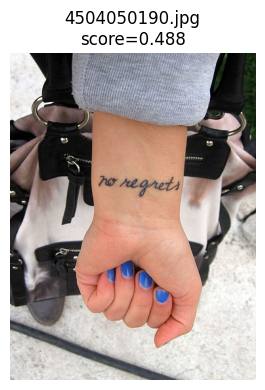

[idx=108815] image=2846843520.jpg | score=0.488
A brown dog is trying to retrive his orange ball that has fallen in a dirt hole .
--------------------------------------------------------------------------------


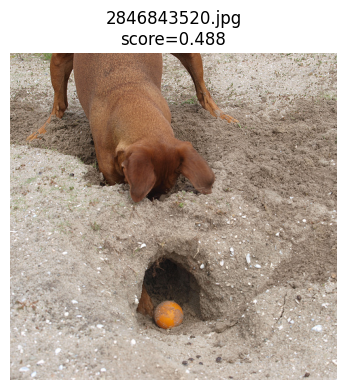

[idx=107655] image=443179792.jpg | score=0.493
The girl in the pink California Santa Cruz sweatshirt was cutting cheese for the picnic .
--------------------------------------------------------------------------------


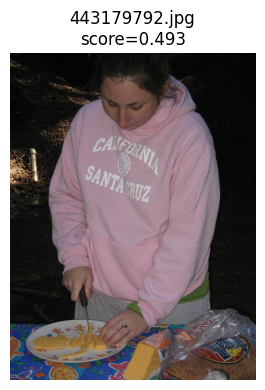

[idx=111274] image=4504050190.jpg | score=0.496
A woman 's hand with blue nail polish and a tattoo that says " no regrets . 
--------------------------------------------------------------------------------


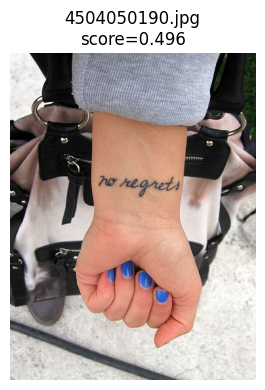

[idx=57697] image=3222749441.jpg | score=0.504
Three people wearing black blindfolds near a " Salvar O Planeta " sign .
--------------------------------------------------------------------------------


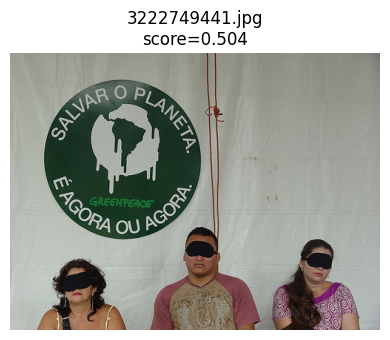

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from src.common import load_data
from src.clip_filter_pairs import compute_clip_pair_scores

# Paths and configuration
input_npz = Path("data/train/train.npz")
images_root = Path("data/train/Images")
device = "cuda" if torch.cuda.is_available() else "cpu"

scores_cache = Path("data/filtered/train_clean_clip_scores.npy")

# 1) Compute or load CLIP scores for all caption–image pairs
if scores_cache.exists():
    print(f"Loading cached CLIP scores from {scores_cache}")
    scores = np.load(scores_cache)
    data = load_data(str(input_npz))
    label = data["captions/label"]
    caption_image_ids = np.argmax(label.astype(np.float32), axis=1).astype(np.int64)
else:
    print("Computing CLIP scores (this may take a few minutes)...")
    scores, caption_image_ids = compute_clip_pair_scores(
        data_path=input_npz,
        images_root=images_root,
        device=device,
    )
    scores_cache.parent.mkdir(parents=True, exist_ok=True)
    np.save(scores_cache, scores)
    print(f"Saved CLIP scores to {scores_cache}")
    data = load_data(str(input_npz))

captions = data["captions/text"]
image_names = data["images/names"]

print(
    f"Scores shape: {scores.shape}, min={scores.min():.3f}, max={scores.max():.3f}, "
    f"mean={scores.mean():.3f}"
)

# 2) Visualize the score distribution
plt.figure(figsize=(6, 4))
plt.hist(scores, bins=80, color="steelblue", alpha=0.8)
for q, color in zip([0.05, 0.10, 0.25], ["orange", "red", "green"]):
    thr = np.quantile(scores, q)
    plt.axvline(thr, color=color, linestyle="--", label=f"q={q:.2f}: {thr:.3f}")
plt.xlabel("CLIP score (caption, GT image)")
plt.ylabel("Count")
plt.title("Distribution of CLIP scores for caption–image pairs")
plt.legend()
plt.tight_layout()
plt.show()


# 3) Helper to show concrete examples at different score extremes

def show_examples(indices, title):
    print("=" * 80)
    print(title)
    print("=" * 80)
    for idx in indices:
        img_id = int(caption_image_ids[idx])
        img_name = image_names[img_id]
        caption = captions[idx]
        score = float(scores[idx])
        print(f"[idx={idx}] image={img_name} | score={score:.3f}")
        print(caption)
        print("-" * 80)
        img_path = images_root / img_name
        img = Image.open(img_path).convert("RGB")
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{img_name}\nscore={score:.3f}")
        plt.tight_layout()
        plt.show()


num_show = 8
order = np.argsort(scores)
worst_indices = order[:num_show]
best_indices = order[-num_show:]

show_examples(worst_indices, f"{num_show} lowest CLIP scores (likely mismatches)")
show_examples(best_indices, f"{num_show} highest CLIP scores")

